In [1]:
import GPyOpt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# enable memory growth on gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
# Datasets for hyperparameter tuning:
# 1. Mordred only dataset all features
# 2. Mordred only dataset top features
# 3. ECFP4 + Mordred independently combined total dataset
# 4. ECFP4 + Mordred independently combined top dataset
bcf_mordred = pd.read_csv('data/bcf_mordred.csv', index_col=0)
bcf_mordred_top = pd.read_csv('data/hyptuning/bcf_mordred_top.csv', index_col=0)
bcf_mordred_ecfp4_total = pd.read_csv('data/hyptuning/bcf_mordred_ecfp4_total.csv', index_col=0)
bcf_mordred_ecfp4_top = pd.read_csv('data/hyptuning/bcf_mordred_ecfp4_top.csv', index_col=0)

# new datasets:
bcf_mordred_expanded = pd.read_csv('data/bcf_mordred_expanded.csv', index_col=0)

In [3]:
# get numpy arrays for training
def get_data(bcf_data, head_columns):
    # keep out final pfas validation set
    bcf_pfas = bcf_data[bcf_data['is_pfas'] == True]
    bcf_nonpfas = bcf_data[bcf_data['is_pfas'] == False]

    # non-pfas used for training and testing set
    head1 = bcf_nonpfas[head_columns]
    data1 = bcf_nonpfas.drop(columns=head_columns, axis=1)
    
    # pfas for final validation
    head2 = bcf_pfas[head_columns]
    data2 = bcf_pfas.drop(columns=head_columns, axis=1)
    
    y = data1.pop('logBCF').to_numpy()
    X = data1.to_numpy()

    y_pfas = data2.pop('logBCF').to_numpy()
    X_pfas = data2.to_numpy()
    
    return X, y, X_pfas, y_pfas

In [4]:
X_m, y_m, X_pfas_m, y_pfas_m = get_data(bcf_mordred, ['CAS', 'Dataset', 'cSMILES', 'is_pfas'])
X_m_top, y_m_top, X_pfas_m_top, y_pfas_m_top = get_data(bcf_mordred_top, ['CAS', 'Dataset', 'cSMILES', 'is_pfas'])
X_d_tot, y_d_tot, X_pfas_d_tot, y_pfas_d_tot = get_data(bcf_mordred_ecfp4_total, ['CAS', 'Dataset', 'cSMILES', 'is_pfas'])
X_d_top, y_d_top, X_pfas_d_top, y_pfas_d_top = get_data(bcf_mordred_ecfp4_top, ['CAS', 'Dataset', 'cSMILES', 'is_pfas'])

In [5]:
# For my neural network I should be able to change number of layers, number of nodes in each layer
# As well as any other hyperparameters on the fly instead of having to write out Sequential each time.
class DNN(keras.Model):
    
    # can use __init__ to instantiate architecture, usually done this way
    # pass arguments array to init, and in init take out private variable initialization
    def __init__(self, n_layers=4, layer_size=200, batch_size=250, learning_rate=0.01, epochs=1000, seed=100):
        super().__init__()
        self.n_layers = n_layers
        self.layer_size = layer_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.seed = seed
        self.generate()
    
    def generate(self):
        self.pipeline = []
        
        for i, layer in enumerate(range(self.n_layers)):
            # batch normalization improves stability of model
            self.pipeline.append(layers.BatchNormalization())
            self.pipeline.append(layers.Dense(self.layer_size, activation='relu'))
            
        self.pipeline.append(layers.BatchNormalization())
        self.pipeline.append(layers.Dense(1, activation = 'linear'))
        
    def call(self, inputs):
        x = inputs
        for layer in self.pipeline:
            x = layer(x)
            
        return x
        
    def fit(self, x_train, y_train, **kwargs):
        tf.random.set_seed(self.seed)
        
        # build creates input layer based on training data shape
        super().build(input_shape=x_train.shape)
        super().compile(optimizer=keras.optimizers.Adam(self.learning_rate), loss='mean_absolute_error', 
                        metrics=['mse', 'mae'])
        return super().fit(x_train, y_train, epochs=self.epochs, batch_size=self.batch_size, **kwargs)

In [6]:
# GyPyOpt bayesian optimization

domain = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.0001, 0.01)},
    {'name': 'n_layers', 'type': 'discrete', 'domain': range(3,10)},
    {'name': 'layer_size', 'type': 'discrete', 'domain': [100, 200, 300, 400, 500, 600, 700, 800]},
    {'name': 'batch_size', 'type': 'discrete', 'domain': [32,64,128,256,512]}
]

class Best:
    def __init__(self, name):
        self.name = name
        self.info = {'score': np.inf, 'history': None, 'metrics': None}  
    
    def summarize(self):
        print('Best model print out for ' + self.name + ':')
        print('--------------------------')
        print('Score:', self.info['score'])
        print('Mean r2:', np.mean(self.info['metrics']['r2']))
        print('Mean mae:', np.mean(self.info['metrics']['mae']))
        print('Mean rmse:', np.mean(self.info['metrics']['rmse']))
        
    def plot_history(self):
        plt.plot(self.info['history'].history['mse'], label='Train')
        plt.plot(self.info['history'].history['val_mse'], label='Validation')

        plt.title('Loss v. Epoch')
        plt.ylabel('MSE')
        plt.xlabel('Epoch')

        plt.legend(loc='upper right')
        plt.show()
    
def feature_set(best, data=(X_m, y_m)):
    
    def search(x):
        X, y = data

        # mse more effective for optimization problems
        mse = []
        metrics = {'r2': [], 'mae': [], 'rmse': []}

        kf = KFold(n_splits=5, shuffle=True, random_state=1)

        for fold_no, (train, test) in enumerate(kf.split(X)):
            X_train, y_train = X[train], y[train]
            X_test, y_test = X[test], y[test]

            X_scaler = StandardScaler()
            X_scaler.fit(X_train)
            X_train_scaled = X_scaler.transform(X_train)
            X_test_scaled = X_scaler.transform(X_test)

            y_scaler = StandardScaler()
            y_scaler.fit(y_train.reshape(-1, 1))
            y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1))
            y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

            model = DNN(learning_rate=float(x[:,0]), n_layers=int(x[:,1]), layer_size=int(x[:,2]), batch_size=int(x[:,3]))
            
            early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                              monitor='val_loss',
                                                              mode='min',
                                                              restore_best_weights=True)

            history = model.fit(X_train_scaled, 
                                y_train_scaled,
                                callbacks=[early_stopping],
                                validation_data=(X_test_scaled, y_test_scaled),
                                verbose=0)

            y_pred = y_scaler.inverse_transform(model.predict(X_test_scaled).reshape(-1,1))

            metrics['r2'].append(r2_score(y_test, y_pred.flatten()))
            metrics['mae'].append(mean_absolute_error(y_test, y_pred.flatten()))
            metrics['rmse'].append(mean_squared_error(y_test, y_pred.flatten(), squared=False))

            mse.append(mean_squared_error(y_test, y_pred.flatten()))

        score = np.mean(mse)

        # save model for final fold if score is best
        if score < best.info['score']:
            best.info['score'] = score
            best.info['history'] = history
            best.info['metrics'] = metrics

        return score
    
    return search

In [9]:
np.random.seed(20)

print('Processing...')
best_m_top = Best('Top Mordred Features')
search_m_top = feature_set(best_m_top, data=(X_m_top, y_m_top))
optimizer_m_top = GPyOpt.methods.BayesianOptimization(f=search_m_top, 
                                                domain=domain, 
                                                model_type='GP', 
                                                acquisition_type='EI',
                                                acquisition_jitter = 0.05,
                                                exact_feval = True,
                                                maximize = False,
                                                verbosity = True)
print('Begin Optimizing...')
optimizer_m_top.run_optimization(max_iter=40)

print('Optimization Completed.')

Processing...
Begin Optimizing...
Optimization Completed.


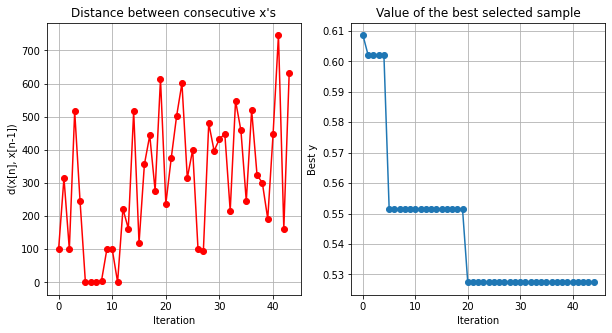

In [10]:
optimizer_m_top.plot_convergence()

In [11]:
# Retrieve best parameters and metrics from Bayesian optimization
best_params_m_top = [(domain[i]['name'], optimum) for i, optimum in enumerate(optimizer_m_top.x_opt)]
print(best_params_m_top)

[('learning_rate', 0.001906801381581014), ('n_layers', 8.0), ('layer_size', 200.0), ('batch_size', 128.0)]


Best model print out for Top Mordred Features:
--------------------------
Score: 0.5273505223879232
Mean r2: 0.7080961632463294
Mean mae: 0.5350504611822323
Mean mse: 0.7246322496972741


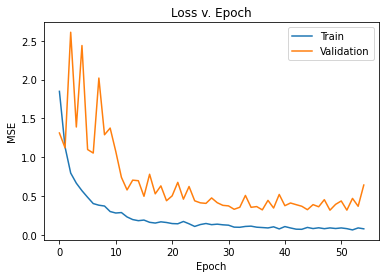

In [12]:
best_m_top.summarize()
best_m_top.plot_history()

In [14]:
print('Processing...')
best_d_top = Best('Top Mordred-ECFP4 Features')
search_d_top = feature_set(best_d_top, data=(X_d_top, y_d_top))
optimizer_d_top = GPyOpt.methods.BayesianOptimization(f=search_d_top, 
                                                domain=domain, 
                                                model_type='GP', 
                                                acquisition_type='EI',
                                                acquisition_jitter = 0.05,
                                                exact_feval = True,
                                                maximize = False,
                                                verbosity = True)
print('Begin Optimizing...')
optimizer_d_top.run_optimization(max_iter=40)

print('Optimization Completed.')

Processing...
Begin Optimizing...
Optimization Completed.


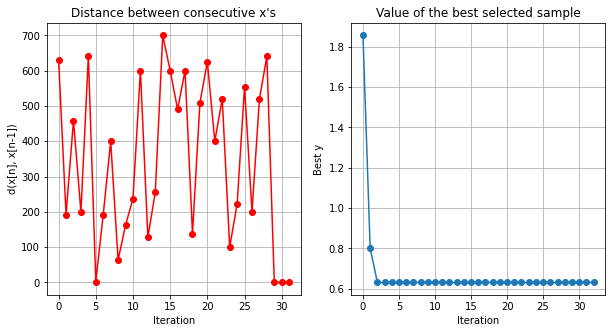

In [15]:
optimizer_d_top.plot_convergence()

In [16]:
# Retrieve best parameters and metrics from Bayesian optimization
best_params_d_top = [(domain[i]['name'], optimum) for i, optimum in enumerate(optimizer_d_top.x_opt)]
print(best_params_d_top)

[('learning_rate', 0.0037192609553884544), ('n_layers', 4.0), ('layer_size', 200.0), ('batch_size', 256.0)]


Best model print out for Top Mordred-ECFP4 Features:
--------------------------
Score: 0.6316063364867232
Mean r2: 0.6501794327381474
Mean mae: 0.5882222070329413
Mean mse: 0.7935959460246397


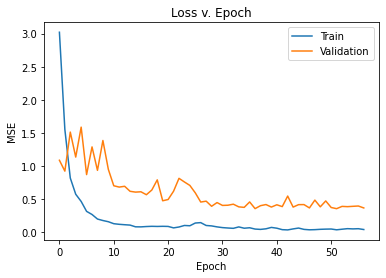

In [17]:
best_d_top.summarize()
best_d_top.plot_history()

In [18]:
print('Processing...')
best_m = Best('All Mordred Features')
search_m = feature_set(best_m, data=(X_m, y_m))
optimizer_m = GPyOpt.methods.BayesianOptimization(f=search_m, 
                                                domain=domain, 
                                                model_type='GP', 
                                                acquisition_type='EI',
                                                acquisition_jitter = 0.05,
                                                exact_feval = True,
                                                maximize = False,
                                                verbosity = True)
print('Begin Optimizing...')
optimizer_m.run_optimization(max_iter=40)

print('Optimization Completed.')

Processing...
Begin Optimizing...
Optimization Completed.


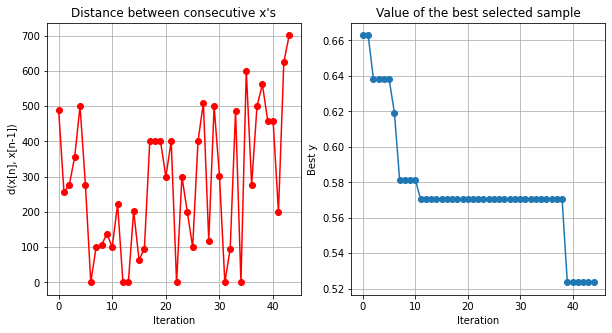

In [19]:
optimizer_m.plot_convergence()

In [20]:
# Retrieve best parameters and metrics from Bayesian optimization
best_params_m = [(domain[i]['name'], optimum) for i, optimum in enumerate(optimizer_m.x_opt)]
print(best_params_m)

[('learning_rate', 0.0017688400062114786), ('n_layers', 9.0), ('layer_size', 200.0), ('batch_size', 512.0)]


Best model print out for All Mordred Features:
--------------------------
Score: 0.5235782985991374
Mean r2: 0.7103498327795761
Mean mae: 0.5258365252145374
Mean mse: 0.7216766635302763


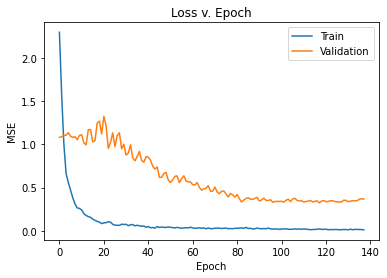

In [21]:
best_m.summarize()
best_m.plot_history()

In [9]:
print('Processing...')
best_d_tot = Best('All Mordred-ECFP4 Features')
search_d_tot = feature_set(best_d_tot, data=(X_d_tot, y_d_tot))
optimizer_d_tot = GPyOpt.methods.BayesianOptimization(f=search_d_tot, 
                                                domain=domain, 
                                                model_type='GP', 
                                                acquisition_type='EI',
                                                acquisition_jitter = 0.05,
                                                exact_feval = True,
                                                maximize = False,
                                                verbosity = True)
print('Begin Optimizing...')
optimizer_d_tot.run_optimization(max_iter=40)

print('Optimization Completed.')

Processing...
Begin Optimizing...
Optimization Completed.


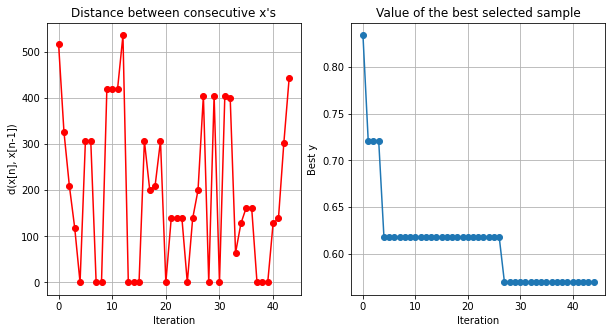

In [10]:
optimizer_d_tot.plot_convergence()

In [11]:
# Retrieve best parameters and metrics from Bayesian optimization
best_params_d_tot = [(domain[i]['name'], optimum) for i, optimum in enumerate(optimizer_d_tot.x_opt)]
print(best_params_d_tot)

[('learning_rate', 0.0013209896831740554), ('n_layers', 4.0), ('layer_size', 100.0), ('batch_size', 128.0)]


Best model print out for All Mordred-ECFP4 Features:
--------------------------
Score: 0.5696830968706411
Mean r2: 0.6844754820832172
Mean mae: 0.5677604162094759
Mean mse: 0.7539107090927485


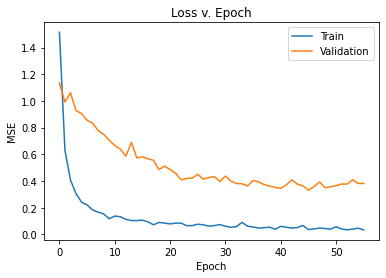

In [12]:
best_d_tot.summarize()
best_d_tot.plot_history()